<a href="https://colab.research.google.com/github/LorenzoTarricone/Deep_Learning/blob/main/Visual_WSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

In today's data-driven society, one of the major challenges lies in finding efficient and accurate ways to bridge the gap between various forms of data, such as visual and textual information. The project at hand revolves around this very challenge. Given a potentially ambiguous word in a limited textual context, we aim to develop a deep learning model capable of selecting the most suitable image, from a set of candidate images, that corresponds to the intended meaning of the target word. This task extends beyond basic image recognition or text analysis and requires harmonising the two. The significance of this problem is reflected in several real-world applications, including improving search engine results, enhancing the user experience on digital platforms, and aiding in teaching machines to comprehend intricate associations between visual and textual data.

This project's task and related datasets are taken from Task 1 of the $17^{th}$ international workshop about Semantic Evaluation [**SemEval-2023**](https://semeval.github.io/SemEval2023/tasks)

#Task Description
Task 1 is centred around the disambiguation of target words in limited textual contexts, as well as their correlation with visual data. Specifically, we are given an ambiguous word and an additional word for context. The aim is to select among 10 candidate images the one representing the ambiguous word in the provided context.  

#Code

What follows is the code used to produce the report that you find in the same GitHub repo where you found this code

-----

In [ ]:
%%capture
pip install transformers

In [ ]:
#Import needed libraries
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from transformers import DistilBertTokenizer, DistilBertModel
from PIL import Image
from PIL import ImageFile
import numpy as np
import pandas as pd
import time
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None

In [ ]:
#Ensuring reproducibility of results
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.cuda.is_available()

True

In [ ]:
#Set paths
#folder_path = '/content/drive/MyDrive/Visual-WSD/semeval-2023-task-1-V-WSD-train-v1/train_v1' #ALAN
#test_folder_path = '/content/drive/MyDrive/Visual-WSD/semeval-2023-task-1-V-WSD-train-v1/test_v1' #ALAN
folder_path = "/content/drive/MyDrive/SemEval2023-WSD/semeval-2023-task-1-V-WSD-train-v1/train_v1" #FABIO
test_folder_path = '/content/drive/MyDrive/SemEval2023-WSD/semeval-2023-task-1-V-WSD-train-v1/test_v1' #ALAN

# Update the data file paths
data_file_path = os.path.join(folder_path, 'train.data.v1.txt')
test_data_file_path = os.path.join(test_folder_path, 'en.test.data.v1.1.txt')
gold_file_path = os.path.join(folder_path, 'train.gold.v1.txt')
test_gold_file_path = os.path.join(test_folder_path, 'en.test.gold.v1.1.txt')
images_folder_path = os.path.join(folder_path, 'train_images_v1')
test_images_folder_path = os.path.join(test_folder_path, 'test_images_v1')
preprocessed_images_folder_path = os.path.join(folder_path, 'train_images_preprocessed')
preprocessed_images_test_folder_path = os.path.join(test_folder_path, 'test_images_preprocessed')
preprocessed_images_clip_folder_path = os.path.join(folder_path, 'train_images_clip')
preprocessed_images_test_clip_folder_path = os.path.join(test_folder_path, 'test_images_clip')

In [ ]:
# Function to load data
def load_data(test=False):
  if test==True: #update paths during testing
    file_path=test_data_file_path
    gold_path=test_gold_file_path
  else:
    file_path=data_file_path
    gold_path=gold_file_path
  df = pd.read_csv(file_path, sep='\t', header=None, names=['target_word', 'full_phrase'] + [f'image_{i}' for i in range(1, 11)])
  df['images'] = df[[f'image_{i}' for i in range(1, 11)]].values.tolist()
  df = df[['target_word', 'full_phrase', 'images']]
  # Load targets
  with open(gold_path, 'r') as f:
    labels = [line.strip() for line in f]
  targets = []
  for i in range(len(df['images'])):
    idx = df['images'][i].index(labels[i])
    targets.append(idx)
  return df, targets

In [ ]:
df, targets = load_data()

----
### Hugging Face libraries approach
#### Vision Text Dual Encoder

This simple encoder uses two ready made encoders from 🤗 and outputs the image and hte word in the same space (here default is 512 dimensional)

In [ ]:
def get_texts(df, index, lenght):
  lista = list(df["full_phrase"])
  extended_lista = lista[-len(lista)//2:] + lista + lista[:len(lista)//2]
  shift = len(lista[-len(lista)//2:])
  return extended_lista[shift + index - (lenght//2):shift + index + (lenght//2)]

In [ ]:
import requests
from transformers import (
    VisionTextDualEncoderModel,
    VisionTextDualEncoderProcessor,
    AutoImageProcessor,
    AutoTokenizer,
)


tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
processor = VisionTextDualEncoderProcessor(image_processor, tokenizer)
model = VisionTextDualEncoderModel.from_vision_text_pretrained(
    "google/vit-base-patch16-224", "bert-base-uncased"
)

correct = 0

for index in range(100):

  inputs = processor(
      text=get_texts(df,index, 10), images=[Image.open(os.path.join(images_folder_path, img)).convert('RGB') for img in df.iloc[index]['images']], return_tensors="pt", padding=True
  )

  outputs = model(
      input_ids=inputs.input_ids,
      attention_mask=inputs.attention_mask,
      pixel_values=inputs.pixel_values,
      return_loss=True,
    )
  loss, logits_per_image = outputs.loss, outputs.logits_per_image  # this is the image-text similarity score

  # inference
  outputs = model(**inputs)
  logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
  probs = logits_per_image.softmax(dim=1)

  probabilities_image = [float(probs[i][5]) for i in range(probs.shape[0])]

  y_hat = probabilities_image.index(max(probabilities_image))

  correct += y_hat == targets[index]

#Expressed as a percentage, as computed on 100 samples
print("Accuracy:  ", correct)

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['c

Accuracy:   12


-----
####ViLT

This model is a vision and text transformer combined. This is offered by 🤗. It only works with two images at the time and one input text

In [ ]:
from transformers import ViltProcessor, ViltForImagesAndTextClassification
##Give jsut an exampels of the probabilities (wrong) that the model give to two images
#For this example we used instance 5
index = 5

images = [Image.open(os.path.join(images_folder_path, img)).convert('RGB') for img in df.iloc[index]['images']]

#"ixia genus"
text = df.iloc[index]["full_phrase"]

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-nlvr2")
model = ViltForImagesAndTextClassification.from_pretrained("dandelin/vilt-b32-finetuned-nlvr2")

#image[0] is the correct one, image[3] is a chessboard

# prepare inputs
encoding = processor([images[0], images[3]], text, return_tensors="pt")

# forward pass
outputs = model(input_ids=encoding.input_ids, pixel_values=encoding.pixel_values.unsqueeze(0))
logits = outputs.logits
probs = logits.softmax(dim=1)
print("Probabilities:", probs)
print("Sentence:  ", text)

Probabilities: tensor([[0.1505, 0.8495]], grad_fn=<SoftmaxBackward0>)
Sentence:   ixia genus


In [ ]:
#Probabilities given. We gave just 15% probability to the correct one
probs

tensor([[0.1505, 0.8495]], grad_fn=<SoftmaxBackward0>)

In [ ]:
#Index of corret image for sample 5
targets[5]

0

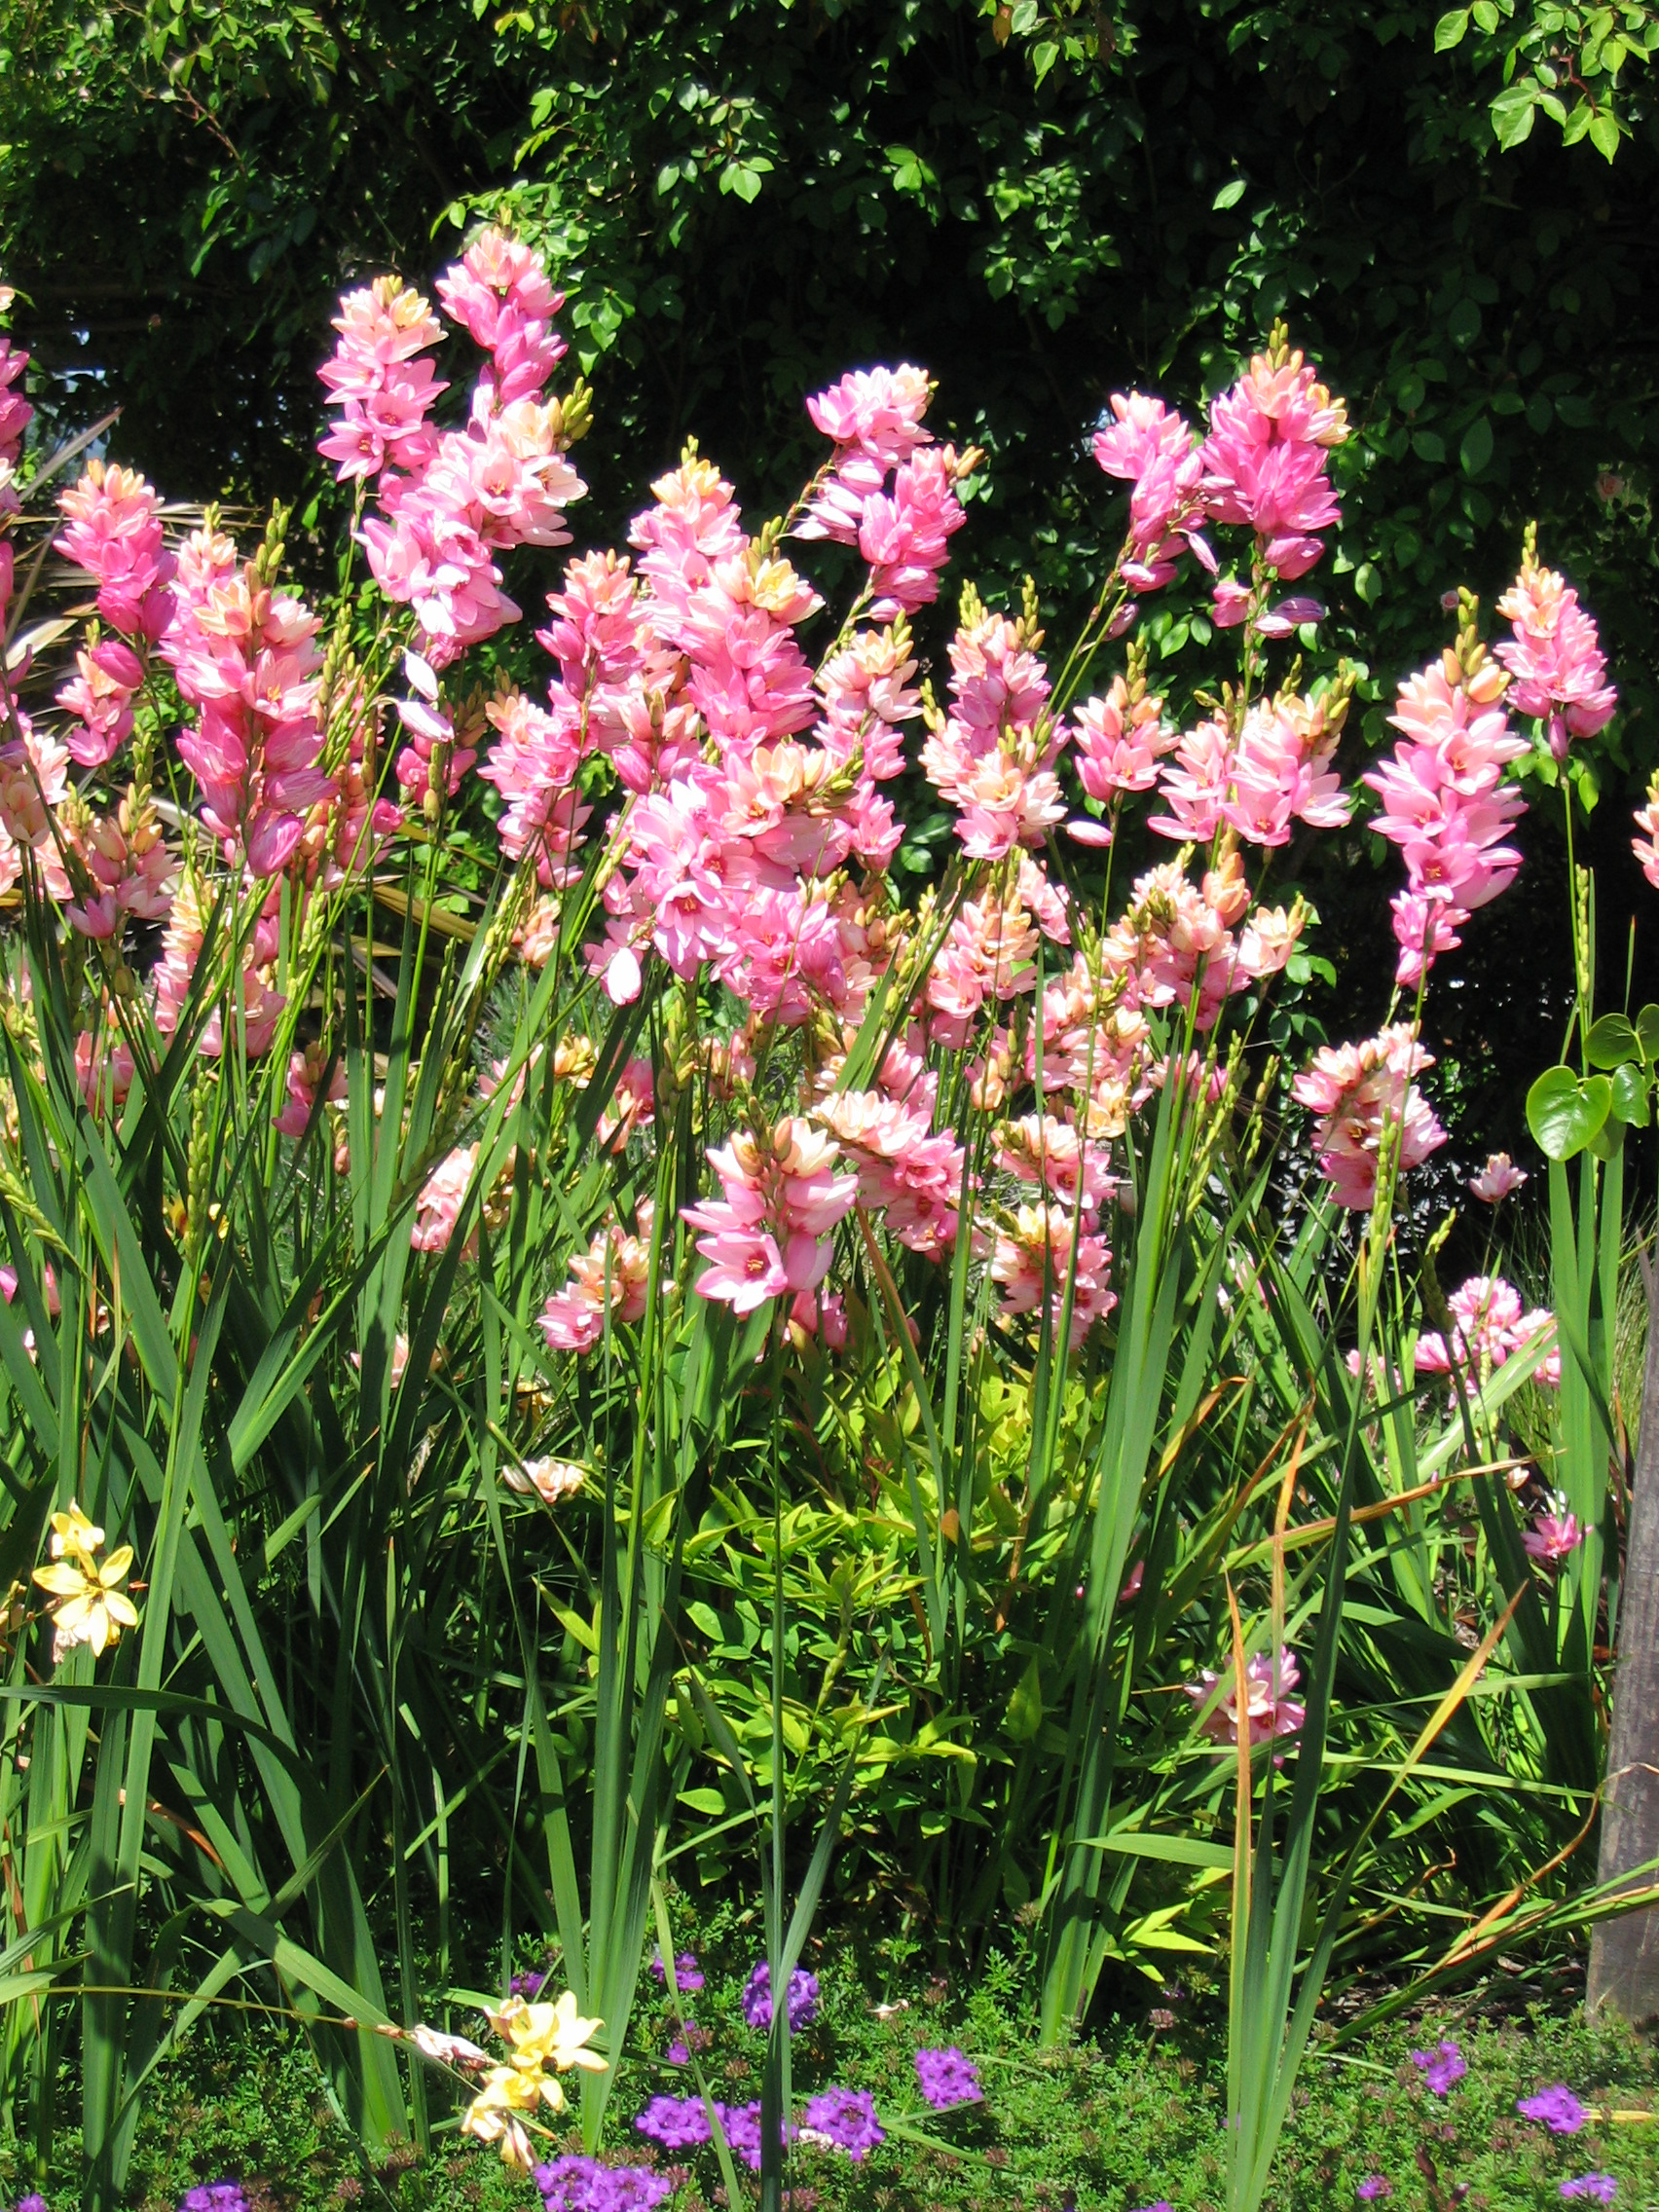

In [ ]:
#correct image
images[0]

#Baseline Approach

##Preprocessing

In the next cell we create a folder that stores the preprocessed images which we will feed to ResNet.
For the ResNet preprocessing, we use the transform() function, which performs the following:
*   This resizes the input image to a specific size. The size of 224x224 is commonly used in deep learning models like AlexNet, VGG, and ResNet, which were originally trained on ImageNet dataset where images were resized to this dimension.

*   transforms.ToTensor(): This converts the PIL Image or a numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]. In other words, it changes the data format to be compatible with PyTorch and scales the values to be between 0 and 1.

*   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]): This normalizes each color channel of the image by subtracting the mean and dividing by the standard deviation. The values specified here are the means and standard deviations of the ImageNet dataset for each of the RGB channels. Normalizing the inputs can help the model learn more effectively because it ensures the input features are on a similar scale, a common prerequisite for many machine learning algorithms.





In [ ]:
import torchvision.transforms.functional as TF
import os

# Create a function that transforms an image and saves it
def preprocess_and_save(image_path, save_path, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    torch.save(image, save_path)

# Define the preprocessing transform function
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Note: this cell was only run twice, once to preprocess the training-set's images and once for the test-set's images.

In [ ]:
df, targets = load_data(test=True)

for index, row in df.iterrows():
    for i, image_name in enumerate(row['images']):
      save_path = os.path.join(preprocessed_images_test_folder_path, f"{image_name}.pt")

      # Check if preprocessed file already exists
      if not os.path.exists(save_path):
        image_path = os.path.join(test_images_folder_path, image_name)
        preprocess_and_save(image_path, save_path, transform)
    if index % 20 == 0:
      print(f"index is {index}, row is {row}")

##Data Visualization

We here visualize an image preprocessed for ResNet50

In [ ]:
images = [torch.load(os.path.join(preprocessed_images_folder_path, f"{img}.pt")) for img in df.loc[0,'images']]

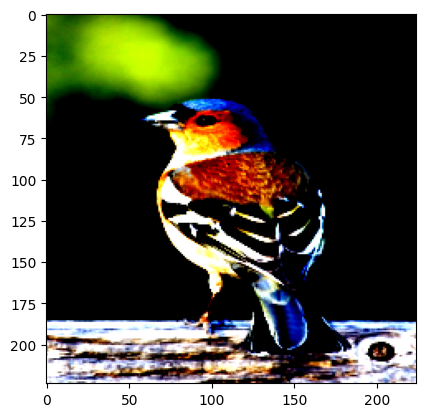

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(images[9].permute(1,2,0))

##Defining Custom Datasets and Custom Models

In [ ]:
# Define DistilBert tokenizer is loaded from the transformers library, which tokenizes input according to DistilBert model's requirements.
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# A custom class 'CustomDataset' is defined which is a subclass of the Dataset class from PyTorch.
class CustomDataset(Dataset):
    def __init__(self, data, targets, images_folder, transform=None, test=True):
        self.data = data
        self.targets = targets
        self.images_folder = images_folder
        self.transform = transform
        self.tokenizer = tokenizer
        self.test = test

    def __len__(self):
        return len(self.data)

    # The __getitem__ function returns the input features and labels for the model for the sample at the given index 'idx'.
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = row['full_phrase']
        # Tokenize the 'text' with padding, truncation and tensor transformation, max_length is set to 16 tokens.
        encoding = self.tokenizer.encode_plus(text, max_length=16, padding='max_length', truncation=True, return_tensors='pt')
        # Loads the corresponding image tensors and stacks them into a single tensor
        images = [torch.load(os.path.join(self.images_folder, f"{img}.pt")) for img in row['images']]
        images = torch.stack(images)
        target = self.targets[idx]
        # Returns the input tensors and the target: the input ids tensor, the attention mask tensor (used by the model to distinguish real tokens from padding tokens), the image tensor, and the target.
        return encoding['input_ids'].squeeze(), encoding['attention_mask'].squeeze(), images, target


In [ ]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
        # Freeze Distilbert layers
        for param in self.text_model.parameters():
            param.requires_grad = False
        # initialize ResNet50
        self.image_model = models.resnet50(pretrained=True)
        # Freeze ResNet layers
        for param in self.image_model.parameters():
            param.requires_grad = False

        # Add three Linear Layers
        self.fc1 = nn.Linear(10768, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 10)

        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask, images):
      text_outputs = self.text_model(input_ids, attention_mask=attention_mask)[0][:,0,:]
      batch_size, num_images, c, h, w = images.shape # Define batch size and images dimensions
      images = images.view(-1, c, h, w)  # reshape to treat each image independently
      image_outputs = self.image_model(images)
      image_outputs = image_outputs.view(batch_size, -1)  # reshape back to original layout, flattening all dimensions except the batch dimension

      x = torch.cat((text_outputs, image_outputs), dim=1)
      x = self.relu(self.fc1(x))  # add first fully connected layer with ReLU activation
      x = self.relu(self.fc2(x))  # add second fully connected layer with ReLU activation
      x = self.fc3(x)  # add third fully connected layer
      return x


CustomModel_2 introduces regularization layers

In [ ]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model=CustomModel()
count_trainable_parameters(model)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvisi

23109130

In [ ]:
class CustomModel_2(nn.Module):
    def __init__(self):
        super(CustomModel_2, self).__init__()
        self.text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
        for param in self.text_model.parameters():
            param.requires_grad = False
        self.image_model = models.resnet50(pretrained=True)
        for param in self.image_model.parameters():
            param.requires_grad = False

        self.dropout1 = nn.Dropout(0.2)  # Dropout layer after concatenation

        self.bn1 = nn.BatchNorm1d(2048)  # Batch normalization layer for first fully connected layer
        self.bn2 = nn.BatchNorm1d(512)   # Batch normalization layer for second fully connected layer

        self.fc1 = nn.Linear(10768, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 10)

        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask, images):
      text_outputs = self.text_model(input_ids, attention_mask=attention_mask)[0][:,0,:]

      batch_size, num_images, c, h, w = images.shape
      images = images.view(-1, c, h, w)  # reshape to treat each image independently
      image_outputs = self.image_model(images)
      image_outputs = image_outputs.view(batch_size, -1)  # reshape back to original layout, flattening all dimensions except the batch dimension

      x = torch.cat((text_outputs, image_outputs), dim=1)
      x = self.dropout1(x)  # apply dropout
      x = self.relu(self.bn1(self.fc1(x)))  # add first fully connected layer with ReLU activation and batch normalization
      x = self.relu(self.bn2(self.fc2(x)))  # add second fully connected layer with ReLU activation and batch normalization
      x = self.fc3(x)  # add third fully connected layer
      return x


CustomModel_3 introduces finetuning of ResNet and a dense layer after DistilBert's outputs, before concatenation to ResNet's outputs.

In [ ]:
class CustomModel_3(nn.Module):
    def __init__(self):
        super(CustomModel_3, self).__init__()
        self.text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
        for param in self.text_model.parameters():
            param.requires_grad = False

        self.image_model = models.resnet50(pretrained=True)
        for param in self.image_model.parameters():
            param.requires_grad = False
        # Unfreeze last block
        for param in self.image_model.layer4.parameters():
            param.requires_grad = True

        # Unfreeze final fully connected layer
        for param in self.image_model.fc.parameters():
            param.requires_grad = True


        self.dropout1 = nn.Dropout(0.3)  # Dropout layer after concatenation
        self.dropout2 = nn.Dropout(0.3)  # Dropout layer for distilbert outputs
        self.dropout3 = nn.Dropout(0.3)  # Dropout layer between relu layers

        self.bn1 = nn.BatchNorm1d(2048)  # Batch normalization layer for first fully connected layer
        self.bn2 = nn.BatchNorm1d(512)   # Batch normalization layer for second fully connected layer
        self.bn3 = nn.BatchNorm1d(256)   # Batch normalization layer for distilbert outputs

        self.fc1 = nn.Linear(768, 256)  # fully connected layer for distilbert outputs
        self.fc2 = nn.Linear(256 + 10000, 2048)  # fully connected layer for concatenated outputs
        self.fc3 = nn.Linear(2048, 512)
        self.fc4 = nn.Linear(512, 10)

        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask, images):
        text_outputs = self.text_model(input_ids, attention_mask=attention_mask)[0][:,0,:]

        text_outputs = self.dropout2(text_outputs)  # apply dropout
        text_outputs = self.relu(self.bn3(self.fc1(text_outputs)))  # apply fc, batch normalization, and relu to distilbert outputs

        batch_size, num_images, c, h, w = images.shape
        images = images.view(-1, c, h, w)  # reshape to treat each image independently
        image_outputs = self.image_model(images)
        image_outputs = image_outputs.view(batch_size, -1)  # reshape back to original layout

        x = torch.cat((text_outputs, image_outputs), dim=1)
        x = self.dropout1(x)  # apply dropout
        x = self.relu(self.bn1(self.fc2(x)))  # apply fc, batch normalization, and relu
        x = self.dropout3(x)
        x = self.relu(self.bn2(self.fc3(x)))  # apply fc, batch normalization, and relu
        x = self.fc4(x)  # apply final fc layer

        return x

In [ ]:
model=CustomModel_3()
count_trainable_parameters(model)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvisi

39276786

## Training and plotting models

We used the following two cells to train and evaluate our models, plotting validation accuracies as well as train and validation losses. We just assign the "model" variable according to the model that we want to train.

In [ ]:
# Initialize lists to monitor train and validation loss
train_losses = []
test_losses = []
test_accuracies=[]

num_epochs=15

df, targets=load_data()

train_df, test_df, train_targets, test_targets = train_test_split(df, targets, test_size=0.2, random_state=42)

#Create dataloaders
train_dataset = CustomDataset(train_df, train_targets, preprocessed_images_folder_path, transform)
test_dataset = CustomDataset(test_df, test_targets, preprocessed_images_folder_path, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=10, pin_memory=True, persistent_workers=True, prefetch_factor=2, drop_last=True, timeout=60)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=10, pin_memory=True, persistent_workers=True, prefetch_factor=2, drop_last=True, timeout=60)

# Initialize the model and move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)
model = CustomModel().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters())

# Initialize the learning rate scheduler
scheduler = StepLR(optimizer, step_size=2, gamma=0.8)

# Train the model
for epoch in range(num_epochs):

    running_train_loss = 0.0
    running_test_loss = 0.0

    model.train()
    start=time.time()
    for i, (input_ids, attention_mask, images, targets) in enumerate(train_loader):
      try:
        input_ids, attention_mask, images, targets = input_ids.to(device), attention_mask.to(device), images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, images)
        loss = criterion(outputs, targets)
        running_train_loss += loss.item()  # add current batch loss
        loss.backward()
        optimizer.step()

        if i % 40 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Step {i}/{len(train_loader)}, Loss: {loss.item()}')

      except RuntimeError as e:
        print(f"Exception occured in batch {i}: {e}")
        print("images ", images)
        continue

    # Calculate average training loss for the epoch and add to list
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Average train loss: {avg_train_loss}')

    # Evaluate on test data after every epoch
    model.eval()
    total = 0
    correct = 0
    counter = 0
    with torch.inference_mode():
        for input_ids, attention_mask, images, targets in test_loader:
            counter += 1
            input_ids, attention_mask, images, targets = input_ids.to(device), attention_mask.to(device), images.to(device), targets.to(device)
            outputs = model(input_ids, attention_mask, images)
            test_loss = criterion(outputs, targets)
            running_test_loss += test_loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            if counter % 40 == 0:
              print(f'Epoch {epoch+1}/{num_epochs}, Step {counter}/{len(test_loader)}, Loss: {test_loss.item()}')
    test_accuracy=100 * correct / total
    print(f'Test Accuracy: {test_accuracy}%')
    test_accuracies.append(test_accuracy)

    # Calculate average validation loss for the epoch and add to list
    avg_test_loss = running_test_loss / len(test_loader)
    print(f'Average test loss: {avg_test_loss}')
    test_losses.append(avg_test_loss)
    scheduler.step()


In [ ]:
import matplotlib.pyplot as plt

# Create list of epochs
epochs = range(1, len(test_accuracies) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot accuracy
ax1.plot(epochs, test_accuracies, 'b', label='Test accuracy')
ax1.set_title('Test Accuracy Over Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot losses
ax2.plot(epochs, train_losses, 'r', label='Train loss')
ax2.plot(epochs, test_losses, 'g', label='Test loss')
ax2.set_title('Losses Over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()

#CLIP

In [ ]:
%%capture
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

##Preprocessing

As we did for ResNet, here we create a folder to store the preprocessed images for CLIP. Instead of the transform function from before, we now use "preprocess", which is the preprocessing function loaded from CLIP.

Note: this cell was only run twice, once to preprocess the training set's images and once for the test set's images.

In [ ]:
import clip

#Load the CLIP model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)
model, preprocess = clip.load("ViT-B/32", device=device)

df, targets = load_data()
#Create a function that transforms an image and saves it
def preprocess_and_save(image_path, save_path):
   image = Image.open(image_path)
   image = preprocess(image)
   torch.save(image, save_path)

for index, row in df.iterrows():
   for i, image_name in enumerate(row['images']):
     save_path = os.path.join(preprocessed_images_clip_folder_path, f"{image_name}.pt")

     #Check if preprocessed file already exists
     if not os.path.exists(save_path):
       image_path = os.path.join(images_folder_path, image_name)
       preprocess_and_save(image_path, save_path)
   if index % 1000 == 0:
     print(f"index is {index}, row is {row}")

##Vanilla Clip


In [ ]:
from torchvision.transforms import Compose, Resize, Normalize, ToTensor

ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None

# Load the CLIP model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)
model, preprocess = clip.load("ViT-B/32", device=device)

def stack_images(images, test=False):
    #return torch.stack([preprocess(Image.open(image_path)) for image_path in images])
    if test:
        return torch.stack([torch.load(os.path.join(preprocessed_images_test_clip_folder_path, f"{img}.pt")) for img in images])
    else:
        return torch.stack([torch.load(os.path.join(preprocessed_images_clip_folder_path, f"{img}.pt")) for img in images])

def compute_similarity(phrase, images):
    with torch.no_grad():
        text_features = model.encode_text(clip.tokenize([phrase]).to(device))
        image_features = model.encode_image(images.to(device))

    return (text_features @ image_features.T).softmax(dim=-1)

def predict_image(df, test=False):
    predictions = []
    for _, row in df.iterrows():
        if _%20==0:
          print("Index ", _, "out of ", df.shape[0])
        images = [img for img in row['images']]
        images = stack_images(images, test)
        similarity_scores = compute_similarity(row['full_phrase'], images)
        best_image_index = similarity_scores.argmax().item()
        predictions.append(best_image_index)
    return predictions

df, targets = load_data(test=True)
predictions = predict_image(df)

# Check accuracy
accuracy = np.mean(np.array(predictions) == np.array(targets))
print(f'Accuracy: {accuracy * 100:.2f}%')


##Wikipedia enhanced CLIP

Wikipedia function

In [ ]:
%%capture
pip install wikipedia-api

In [ ]:
%%capture
!pip install -qU openai

In [ ]:
import wikipediaapi
from transformers import CLIPTokenizer
import openai

#we removed the OpenAI api key due to privacy reasons
openai.api_key = "API_KEY"
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

def get_wikipedia_summary(sentence, word):

    wiki_wiki = wikipediaapi.Wikipedia('en')
    page1 = wiki_wiki.page(sentence)

    if page1.exists() and "may refer to" not in page1.text:
        summary = page1.summary
        # Extract the first two sentences of the summary
        sentences = summary.split(".")
        first_two_sentences = ". ".join(sentences[:2])
        tokens = tokenizer.tokenize(first_two_sentences)
        if len(tokens) >= 73:
          first_two_sentences = tokenizer.convert_tokens_to_string(tokens[:73])
        return first_two_sentences
    else:
      page2 =  wiki_wiki.page(word)
      if page2.exists() and "may refer to" not in page2.text:
        summary = page2.summary
        # Extract the first two sentences of the summary
        sentences = summary.split(".")
        first_two_sentences = ". ".join(sentences[:2])
        tokens = tokenizer.tokenize(first_two_sentences)
        if len(tokens) >= 73:
          first_two_sentences = tokenizer.convert_tokens_to_string(tokens[:73])
        return first_two_sentences
      else:
        print("The word is not on wiki, using GPT 3.5 instead")
        success=True
        while success:
            try:
                response = openai.ChatCompletion.create(model="gpt-3.5-turbo", messages=[
                {"role": "system", "content": "You are a helpful assistant that explains things in a simple and concise way."},
                {"role": "user", "content": f'Provide a simple and concise definition for \"{sentence}\" in two sentences. Keep the explanation basic, use simple words, and be brief.'}])
            except:
                continue
            success=False
        model_response=response['choices'][0]['message']['content']
        if "sorry" in model_response or "not sure" in model_response:
          return sentence
        tokens = tokenizer.tokenize(model_response)
        if len(tokens) >= 73:
          model_response = tokenizer.convert_tokens_to_string(tokens[:73])
        print("GPT output (truncated): ", model_response)
        return model_response


In [ ]:
from torchvision.transforms import Compose, Resize, Normalize, ToTensor

# Load the CLIP model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)
model, preprocess = clip.load("ViT-B/32", device=device)

def preprocess_images(images, test=False, preprocessed=False):
    #images have already been preprocessed and stored in a folder
    if not preprocessed:
        return torch.stack([preprocess(Image.open(image_path)) for image_path in images])
    elif test and preprocessed:
        return torch.stack([torch.load(os.path.join(preprocessed_images_test_clip_folder_path, f"{img}.pt")) for img in images])
    elif preprocessed:
        return torch.stack([torch.load(os.path.join(preprocessed_images_clip_folder_path, f"{img}.pt")) for img in images])



def compute_similarity(phrase, images):
    with torch.no_grad():
        text_features = model.encode_text(clip.tokenize([phrase]).to(device))
        image_features = model.encode_image(images.to(device))
    return (text_features @ image_features.T).softmax(dim=-1)

def predict_image(df, test=False, preprocessed = False):
    predictions = []
    for _, row in df.iterrows():
        if _%20==0:
            print("Index ", _, "out of ", df.shape[0])
        if preprocessed:
          images = [img for img in row['images']]
        elif test and not preprocessed:
          images = [os.path.join(test_images_folder_path, img) for img in row['images']]
        else:
          images = [os.path.join(images_folder_path, img) for img in row['images']]
        images = preprocess_images(images, test)
        similarity_scores = compute_similarity(get_wikipedia_summary(row['full_phrase'], row['target_word']), images)
        best_image_index = similarity_scores.argmax().item()
        predictions.append(best_image_index)
    return predictions

df, targets = load_data(test=True)
predictions = predict_image(df, test=True, preprocessed=False)

# Check accuracy
accuracy = np.mean(np.array(predictions) == np.array(targets))
print(f'Accuracy: {accuracy * 100:.2f}%')
